In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from utils import encode, ofdm, channels, audio, decode,preamble
import sounddevice as sd
cwd = os.getcwd()

In [2]:
DFT_LENGTH = 4096
CP_LENGTH = 512
OFDM_LENGTH = 4608
silence_duration = 1
chirp_duration = 1
fs = 48000

low_freq = 1000
high_freq = 10000
double_chirp = False

encode_method = 'qpsk'
if encode_method == 'bpsk':
    bits_per_symbol = 1
elif encode_method == 'qpsk':
    bits_per_symbol = 2

In [3]:
# Generate a bit array as data to transmit
new = True

spb = ofdm.subcarriers_per_block(fs,DFT_LENGTH,low_freq,high_freq)

if new:
    np.random.seed(8)
    encoded = np.random.randint(2, size=int(3 * 2 * spb * 128))
    np.savetxt('encoded', encoded, fmt='%i')

# Load a saved bit array
encoded = np.loadtxt('encoded', dtype=np.int32)

In [4]:
if encode_method == 'qpsk':
    symbols = encode.qpsk_encode(encoded)
elif encode_method == 'bpsk':
    symbols = encode.bpsk_encode(encoded)

shifted = ofdm.subcarrier_shift_gaussian(symbols, DFT_LENGTH, fs, low_freq, high_freq, 0.01, bits_per_symbol, constellation=encode_method)
ofdm_data = ofdm.symbols_to_ofdm(shifted, DFT_LENGTH, CP_LENGTH)

In [5]:
#chirp between frame
chirp_inter = preamble.generate_chirp(chirp_duration, fs, low=low_freq, high=high_freq, silence_duration=0, double=double_chirp)

In [6]:
#generate known ofdm symbols
known_ofdm = True
repeat_time = 4

known_ofdm_data = preamble.load_known_ofdm(CP_LENGTH,repeat_time)

In [15]:
reshape_ofdm = np.reshape(ofdm_data,(-1,OFDM_LENGTH))

print(reshape_ofdm.shape)
i=0
frame_audio = np.array([])
while (i+128) < reshape_ofdm.shape[0]:
    ofdm_block = reshape_ofdm[i:i+128,:].flatten()
    frame = preamble.frame_assemble(chirp_inter,16*known_ofdm_data,25*ofdm_block)
    frame_audio = np.append(frame_audio,frame)
    i += 128

ofdm_block = reshape_ofdm[i:,:].flatten()
frame = preamble.frame_assemble(chirp_inter,16*known_ofdm_data,25*ofdm_block)
frame_audio = np.append(frame_audio,frame)

start_audio = preamble.transmission_start(fs,low_freq,high_freq,silence_duration)
end_audio = preamble.transmission_end(fs,low_freq,high_freq,silence_duration)

output_audio = np.concatenate((start_audio,frame_audio,end_audio))

(384, 4608)


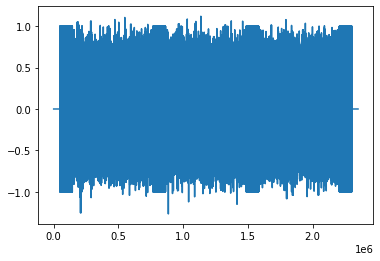

In [16]:
plt.plot(output_audio)

In [8]:
#save and play
audio.signal_to_wav(np.real(output_audio), fs, 'ofdm_tester', 'audio_files')
sd.play(output_audio,fs,blocking=True)


: 

In [ ]:
# Send through Octagon
octagon = channels.octagon(os.path.join(cwd, "audio_files"), fs)
impulse_channel = np.array([1])
channel = np.ones(10)
H = np.fft.fft(channel)

received = channels.channel_output(channel, np.real(ofdm_data))
fft = ofdm.ofdm_to_fourier(received[:ofdm_data.size], DFT_LENGTH, CP_LENGTH)
discarded = ofdm.subcarrier_extract(fft, DFT_LENGTH, fs, low_freq, high_freq)
deconvolved = ofdm.deconvolve(discarded, H, DFT_LENGTH, fs, low_freq, high_freq)
if encode_method == 'qpsk':
    decoded = decode.qpsk_decode(deconvolved)
elif encode_method == 'bpsk':
    decoded = decode.bpsk_decode(deconvolved)
print(encoded.size, decoded.size)
print("source:\n", encoded[:30])
print("decoded:\n", decoded[:30])



In [ ]:
equality = encoded == decoded[:encoded.size]
equality = equality[10:]
print("correct rate:\n", np.sum(equality.astype(int))/equality.size)